# Whale Identification

The purpose of this model is create a whale identification model based on previous data. First step is prepare the data to be digested by the model.

# Organizing the Dataset

In [54]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from itertools import combinations, chain
from torch.utils.data import Dataset, DataLoader, random_split

In [25]:
class WhaleDataset(Dataset):
    """
    Creates the dataset to train the model.
    """
    def __init__(self, csv_file, root_dir, transform=None, pos_ratio=0.619):
        """     
        Args: 
            root_dir (string): Path to diretory with images.
            csv_file (string): Path to csv with all the images.
            transform (callable): Optional transforms to be applied to images.
            pos_ratio (float): Ratio of positive/negative matches present in dataset.
        """
        # Prepare DataFrame with the pair of images
        combined_pos_list = []
        whales_frame = pd.read_csv(csv_file)
        # Series with list of images for each ID
        pos_img_series = whales_frame.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")["Image"]
        # Series of non-matching images
        false_img_series = whales_frame.groupby('Id').agg(lambda x: x.iloc[0])["Image"]
        # Calculates combinations of positive matches
        for idx, v in pos_img_series.iteritems():
            imgs = v.split(",")
            combined = combinations(imgs, 2)
            combined_pos_list.append(combined)
        
        # Positive matches
        positive = pd.DataFrame(list(chain(*combined_pos_list)), columns=["image_1", "image_2"])
        positive["label"] = 1
        
        # Calculates negative matches for all idx
        combined_neg = combinations(false_img_series, 2)
        negative = pd.DataFrame(list(combined_neg), columns=["image_1", "image_2"])
        negative["label"] = 0
        
        
        # Join both frames
        self.data = pd.concat([positive, negative], axis=0, join='outer', ignore_index=True)
        
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        # Load images
        img_1_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 0])
        img_2_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 1])
        img_1 = Image.open(img_1_path).convert('RGB')
        img_2 = Image.open(img_2_path).convert('RGB')
        
        
        # Data augmentation
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
        # Label for image pair
        label = self.data.iloc[idx, 2]
        
        # Output
        sample = (img_1, img_2, label)
        
        return sample

In [50]:
csv_file = 'humpback-whale-identification/train.csv'
root_dir = 'humpback-whale-identification/train'
# data augmentation
transform = T.Compose([T.ColorJitter(.25, .25, .25,),
                       T.Resize(500),
                       T.RandomRotation(5),
                       T.FiveCrop((300)),
                       T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops]))
                      ])
whale_dataset = WhaleDataset(csv_file, root_dir, transform)

In [51]:
data_loader = DataLoader(whale_dataset,
                         batch_size=1,
                         shuffle=True)

In [52]:
len(whale_dataset)

12592447

torch.Size([1, 5, 3, 300, 300])
tensor([0])


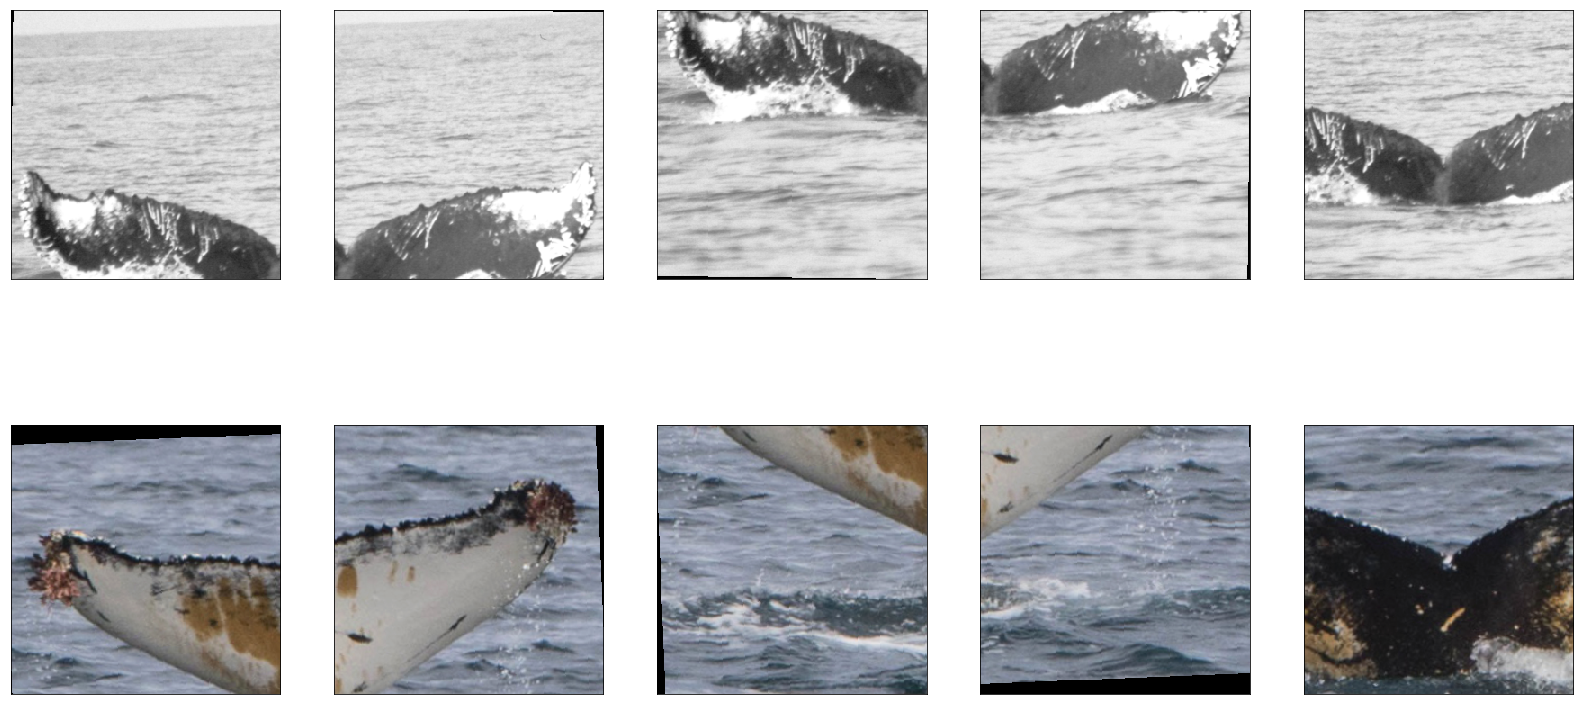

In [53]:
# Check data
img1, img2, label = iter(data_loader).next()

# 5 cropped images
print(img1.size())
bs, ncrops, c, h, w = img1.size()
# 1 item of the batch
imgs_1 = img1[0].numpy()
imgs_2 = img2[0].numpy()
f = plt.figure(figsize=(28, 14))
# For each crop
for idx in range(5):
    ax1 = f.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])
    ax2 = f.add_subplot(2, 5, idx + 6, xticks=[], yticks=[])
    
    ax1.imshow(np.transpose(imgs_1[idx], (1, 2, 0)))
    ax2.imshow(np.transpose(imgs_2[idx], (1, 2, 0)))
print(label)


In [55]:
# Split Data
train_size = int(len(whale_dataset) * .8)
test_size = len(whale_dataset) - train_size
train_dataset, test_dataset = random_split(whale_dataset, [train_size, test_size])

# Dataloader
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True
                         )
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=True
                         )

#### Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Building and Training a Model

Model from the ground

In [57]:
import torch
from torch import nn
from torch import optim
import torch.functional as F

In [ ]:
# Model
class 

Using transfer learning as features extractors.

In [ ]:
# Load Pretrained Models

resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

alexnet = models.alexnet(pretrained=True)

squeezenet = models.squeezenet1_0(pretrained=True)

vgg16 = models.vgg19(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

densenet121 = models.densenet121(pretrained=True)
densenet161 = models.densenet161(pretrained=True)

inception3 = models.inception_v3(pretrained=True)

In [ ]:
# Add attributes to models
resnet152.name = 'ResNet_152'
resnet152.last_layer_attr = 'fc'

vgg19.name = 'VGG_19'
vgg19.last_layer_attr = 'classifier'

densenet161.name = 'DenseNet_161'
densenet161.last_layer_attr = 'classifier'

# List of Models and its last layer
transfer_models = [resnet152,
                    vgg19,
                    densenet161]